In [1]:
import pandas as pd
import sqlalchemy as sa

# Create engine (same as before)
engine = sa.create_engine(
    "mssql+pyodbc://@.\\SQLEXPRESS/ecommerce"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)

# SQL query
query = "SELECT * FROM customers"

# Fetch data
df = pd.read_sql(query, engine)

print(df.head())
print(df.shape)

                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   
2  4e7b3e00288586ebd08712fdd0374a03  060e732b5b29e8181a18229c7b0b2b5e   
3  b2b6027bc5c5109e529d4dc6358b12c3  259dac757896d24d7702b9acbbff3f3c   
4  4f2d8ab171c80ec8364f7c12e35b23ad  345ecd01c38d18a9036ed96c73b8d066   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
2                      1151              sao paulo             SP  
3                      8775        mogi das cruzes             SP  
4                     13056               campinas             SP  
(99441, 5)


In [12]:
#list all unique cities where customer are located.
query= """select distinct(customer_city) from customers"""
df=pd.read_sql(query,engine)
df


,customer_city
0,abadia dos dourados
1,abadiania
2,abaete
3,abaetetuba
4,abaiara
...,...
4114,xinguara
4115,xique-xique
4116,zacarias
4117,ze doca


In [22]:
#count the number of order placed in 2017
query="""select count(order_id) from orders where year(order_purchase_timestamp)='2017'"""
df=pd.read_sql(query,engine)
"total orders placed in 2017 are ",df

('total orders placed in 2017 are ',
         
 0  45101)

In [31]:
#find the  total sales of per category
import pandas as pd
import sqlalchemy as sa

# Create engine (same as before)
engine = sa.create_engine(
    "mssql+pyodbc://@.\\SQLEXPRESS/ecommerce"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)

query="""select products.product_category,round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by product_category"""
df=pd.read_sql(query,engine)

print(df.head())


                  product_category      sales
0                    House comfort   84329.06
1                  fixed telephony  207010.26
2                       Cool Stuff  779698.00
3                     ELECTRICES 2  124563.46
4  Construction Tools Construction  241475.63


In [16]:
#calculate the percantage of orders that were paid in installments.
query="""select (100*sum(case when payment_installments >= 1  then 1 else 0 end))/count(*)
as 
percantage_installments
from payments"""

df=pd.read_sql(query,engine)

df

,percantage_installments
0,99


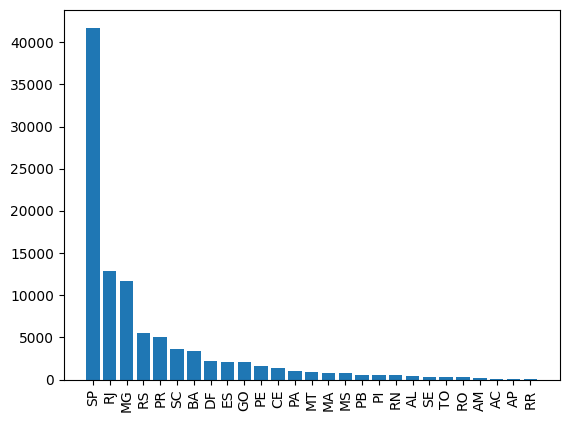

In [26]:
#count the number of customers from each state
import matplotlib.pyplot as plt
query="""select 
count(customer_id) per_state_customers,
customer_state
from customers
group by customer_state
order by per_state_customers desc"""
df=pd.read_sql(query,engine)
df
plt.bar(df['customer_state'],df['per_state_customers'])
plt.xticks(rotation=90)
plt.show()



<function matplotlib.pyplot.show(close=None, block=None)>

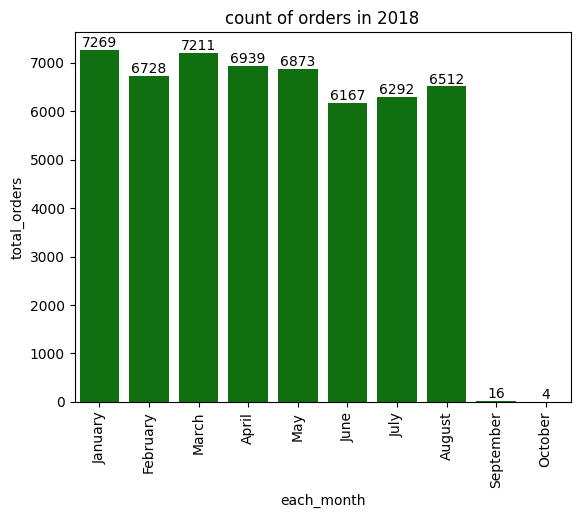

In [47]:
#calculate number of orders per month in 2018
import seaborn as sns
query="""select
count(order_id) total_orders,
datename(month,order_purchase_timestamp)as each_month,
month(order_purchase_timestamp) as month_num
from orders
where order_purchase_timestamp>='2018-01-01' and order_purchase_timestamp<'2019-01-01'
group by datename(month,order_purchase_timestamp),month(order_purchase_timestamp)
order by month_num """
df=pd.read_sql(query,engine)
o=["January","February","March","April","May","June","July","August","September","october","November","December"]
ax=sns.barplot(x=df["each_month"],y=df["total_orders"],color="green")
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0])
plt.title("count of orders in 2018")

plt.show

In [10]:
import pandas as pd
import sqlalchemy as sa
import seaborn as sns
import matplotlib.pyplot as plt

#Create engine (same as before)
engine = sa.create_engine(
    "mssql+pyodbc://@.\\SQLEXPRESS/ecommerce"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)


#find the average number of products per order,grouped by customer city
query="""with count_per_order as (select
o.order_id,
o.customer_id,
count(ot.order_id)as no_of_orders
from orders o
 left join order_items ot
on o.order_id=ot.order_id
group by o.order_id,o.customer_id)

select customers.customer_city,avg(count_per_order.no_of_orders) avg_orders
from customers left join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city
order by avg_orders desc
 """
df=pd.read_sql(query,engine)
df.head(10)


,customer_city,avg_orders
0,padre carvalho,7
1,candido godoi,6
2,celso ramos,6
3,datas,6
4,matias olimpio,5
5,morro de sao paulo,4
6,curralinho,4
7,cidelandia,4
8,picarra,4
9,chapadao do lageado,3


In [15]:
#--calculate the percentage of total  revenue contributed by each category
query="""select 
round((sum(pay.payment_value)/( select sum(payment_value) from payments))* 100,2)sales_percentage,
p.product_category category
from order_items o
left join products p
on o.product_id=p.product_id
left join payments pay
on pay.order_id=o.order_id
group by p.product_category
order by sales_percentage desc
 """
df=pd.read_sql(query,engine)
df.head(5)

,sales_percentage,category
0,10.70,bed table bath
1,10.35,HEALTH BEAUTY
2,9.90,computer accessories
3,8.93,Furniture Decoration
4,8.93,Watches present


In [22]:
#identify the coorelation between product prize and the number of times a product has been purchased.
import numpy as np
query="""select products.product_category,
count(order_items.product_id) count_of_purchaseId,
round(avg(order_items.price),2) avg_price
from products join  order_items
on products.product_id=order_items.product_id
group by products.product_category;
 """
df=pd.read_sql(query,engine)
df.head(5)
arr1=df["count_of_purchaseId"]
arr2=df["avg_price"]
a=np.corrcoef([arr1,arr2])
print("correation between count of purchaseid and price of order is--",a[0][1])
 

correation between count of purchaseid and price of order is-- -0.10631514167157567


In [33]:
#--calculate the total revenue by each sellers and rank them by revenue
import matplotlib.pyplot as plt
import seaborn as sns
query="""select
seller_id,
total_revenue,
rank() over(order by total_revenue desc) as rank_by_revenue
from
(select 
oi.seller_id,
sum(p.payment_value) as total_revenue
from payments p
join order_items oi
on oi.order_id=p.order_id
group by oi.seller_id)t
 """
df=pd.read_sql(query,engine)
df.head(5)




,seller_id,total_revenue,rank_by_revenue
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


In [34]:
#--calculate the moving average of order values for each customer over their order history.
import pandas as pd
import sqlalchemy as sa
import seaborn as sns
import matplotlib.pyplot as plt
query="""select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id)t"""
df=pd.read_sql(query,engine)
df.head(5)



,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01


In [2]:
#write cumulative  sales per month for each year
import pandas as pd
import sqlalchemy as sa
import seaborn as sns
import matplotlib.pyplot as plt
engine = sa.create_engine(
    "mssql+pyodbc://@.\\SQLEXPRESS/ecommerce"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)

query = """select 
years,months,payment,sum(payment) over(order by years ,months) as cumulative_sales
from(select year(orders.order_purchase_timestamp) as years,
datename(month,orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp),datename(month,orders.order_purchase_timestamp)
)t
"""
df=pd.read_sql(query,engine)
df


,years,months,payment,cumulative_sales
0,2016,December,19.62,19.62
1,2016,October,59090.48,59110.10
2,2016,September,252.24,59362.34
3,2017,April,417788.03,477150.37
4,2017,August,674396.32,1151546.69
5,2017,December,878401.48,2029948.17
6,2017,February,291908.01,2321856.18
7,2017,January,138488.04,2460344.22
8,2017,July,592382.92,3052727.14
9,2017,June,511276.38,3564003.52


In [3]:
#calculate the year over year  growth rate of total sales.
query="""select 
years,
payment,
lag(payment) over(order by years) as previous_value,
(payment-lag(payment) over(order by years))/(lag(payment) over(order by years))*100 as yoy_growth
from
(select
year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp))t"""
df=pd.read_sql(query,engine)
df



,years,payment,previous_value,yoy_growth
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.703761
2,2018,8699763.05,7249746.73,20.000924


<function matplotlib.pyplot.show(close=None, block=None)>

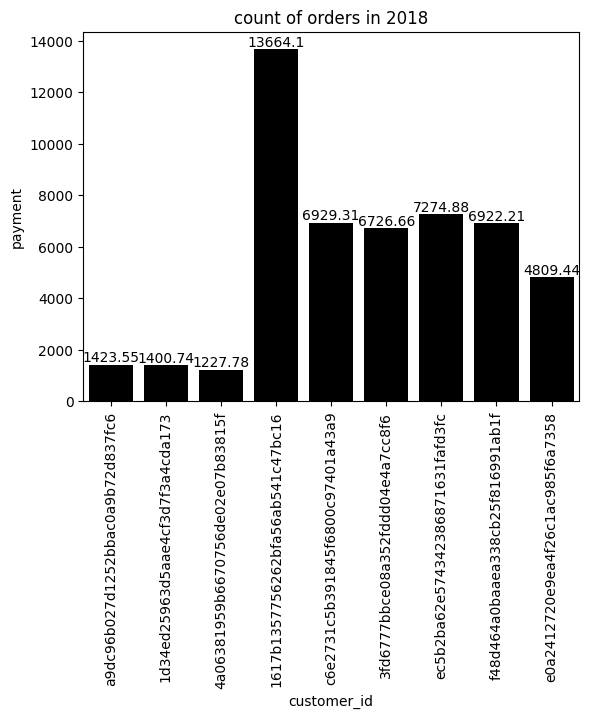

In [12]:
#Identify the top 3 customers who spent the most money in each year.
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3"""
df=pd.read_sql(query,engine)
ax=sns.barplot(x=df["customer_id"],y=df["payment"],color="black")
plt.xticks(rotation=90)
ax.bar_label(ax.containers[0])
plt.title("count of orders in 2018")

plt.show

